## `sm_taylor_diagram_mohc_hadgem3-gc31-ll-historical.ipynb`: create taylor diagram of HadGEM3-GC3.1-LL ensemble members.
### NOTE: run`sm_taylor_diagram_cccma_historical.ipynb` can be run afterwards to compare one ensemble member from the HadGEM3-GC3.1-LL with Canadian model

In [1]:
import context
import warnings
import intake
import xarray as xr 
import matplotlib.pyplot as plt 
import pandas as pd
import cftime
import gcsfs
import cartopy.crs as ccrs
from pathlib import Path
import pandas as pd
from a448_lib import data_read
import fsspec
import cmocean as cm
import cartopy.feature as cfeature
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import skill_metrics as sm
from sys import version_info
from skill_metrics import error_check_stats
from skill_metrics import centered_rms_dev

found this_dir=PosixPath('/home/jovyan/work/data_share')
found lib_dir=PosixPath('/home/jovyan/work/data_share/a448_lib')
******************************
context imported. Front of path:
/home/jovyan/work/data_share
back of path: /home/jovyan/.ipython
******************************



### Grab json file with all the data from CMIP6

In [17]:
csv_filename = "pangeo-cmip6.csv"
root = "https://storage.googleapis.com/cmip6"
if Path(csv_filename).is_file():
    print(f"found {csv_filename}")
else:
    print(f"downloading {csv_filename}")
    data_read.download(csv_filename,root=root)
    
json_filename="https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

found pangeo-cmip6.csv


* make a dataframe from the csv version

In [18]:
catalog_df=pd.read_csv(csv_filename)
catalog_df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tauv,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ta,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [19]:
col = intake.open_esm_datastore(json_filename)

## Grab all Hadgem-gc31-LL experimental runs

In [20]:
source = "HadGEM3-GC31-LL"
query = dict(
    experiment_id=['historical'],
    institution_id = "MOHC",
    source_id = source,
    table_id=["SImon"],
    variable_id=['sithick'])

col_subset = col.search(require_all_on=["source_id"],**query)

In [21]:
list_of_members = col_subset.df

#### Define Taylor Statistics Function

In [22]:
def taylor_statistics(predicted,reference,field=''):
    '''
    Calculates the statistics needed to create a Taylor diagram as 
    described in Taylor (2001) using the data provided in the predicted 
    field (PREDICTED) and the reference field (REFERENCE).
    
    The statistics are returned in the STATS dictionary.
    If a dictionary is provided for PREDICTED or REFERENCE, then 
    the name of the field must be supplied in FIELD.
  
    The function currently supports dictionaries, lists, and np.ndarray,
    types for the PREDICTED and REFERENCE variables.
 
    Input:
    PREDICTED : predicted field
    REFERENCE : reference field
    FIELD     : name of field to use in PREDICTED and REFERENCE dictionaries
                (optional)
    NORM      : logical flag specifying statistics are to be normalized 
                with respect to standard deviation of reference field
                = True,  statistics are normalized
                = False, statistics are not normalized
 
    Output:
    STATS          : dictionary containing statistics
    STATS['ccoef'] : correlation coefficients (R)
    STATS['crmsd'] : centered root-mean-square (RMS) differences (E')
    STATS['sdev']  : standard deviations
 
    Each of these outputs are one-dimensional with the same length. 
    First index corresponds to the reference series for the diagram. 
    For example SDEV[1] is the standard deviation of the reference 
    series (sigma_r) and SDEV[2:N] are the standard deviations of the 
    other (predicted) series.
 
    Reference:
    
    Taylor, K. E. (2001), Summarizing multiple aspects of model 
      performance in a single diagram, J. Geophys. Res., 106(D7),
      7183-7192, doi:10.1029/2000JD900719.
    Author: Peter A. Rochford
        Symplectic, LLC
        www.thesymplectic.com
        prochford@thesymplectic.com
    Created on Dec 3, 2016
    '''

    p, r = error_check_stats(predicted,reference,field)

    # Calculate correlation coefficient
    ccoef = np.corrcoef(p,r)
    ccoef = ccoef[0]

    # Calculate centered root-mean-square (RMS) difference (E')^2
    crmsd = [0.0, centered_rms_dev(p,r)]

    # Calculate standard deviation of predicted field w.r.t N (sigma_p)
    sdevp = np.std(p)
    
    # Calculate standard deviation of reference field w.r.t N (sigma_r)
    sdevr = np.std(r)
    sdev = [sdevr, sdevp];

    # Store statistics in a dictionary
    stats = {'ccoef': ccoef, 'crmsd': crmsd, 'sdev': sdev}
    return stats

#### These are the models we will be comparing. Treat member 0 (r1i1p2f1 as the reference model)

In [23]:
member_ids = list_of_members['member_id']
subset_member_ids = member_ids[0:4]
print(subset_member_ids)

0    r2i1p1f3
1    r3i1p1f3
2    r1i1p1f3
3    r4i1p1f3
Name: member_id, dtype: object


In [24]:
# setting up reference 
my_memberid = "member_id==" + "\'" + str(subset_member_ids[3]) +"\'"
filenames = list_of_members.query(my_memberid)['zstore'].iloc[0]
reference =xr.open_zarr(fsspec.get_mapper(filenames), consolidated=True)

mohc_pd = reference['sithick'][-1,:,:].to_dataframe()
mohc_pd = mohc_pd.dropna()
mohc_pd
%store mohc_pd

Stored 'mohc_pd' (DataFrame)


In [25]:
my_memberid = "member_id==" + "\'" + str(subset_member_ids[1]) +"\'"
filenames = list_of_members.query(my_memberid)['zstore'].iloc[0]
reference =xr.open_zarr(fsspec.get_mapper(filenames), consolidated=True)

reference_pd = reference['sithick'][-1,:,:].to_dataframe()
reference_pd = reference_pd.rename(columns={"sithick": "sithick_reference"})
reference_pd = reference_pd.dropna()

In [26]:
#bias = np.zeros((4))

# setting up reference 
my_memberid = "member_id==" + "\'" + str(subset_member_ids[0]) +"\'"
filenames = list_of_members.query(my_memberid)['zstore'].iloc[0]
reference =xr.open_zarr(fsspec.get_mapper(filenames), consolidated=True)

reference_pd = reference['sithick'][-1,:,:].to_dataframe()
reference_pd = reference_pd.rename(columns={"sithick": "sithick_reference"})
reference_pd = reference_pd.dropna()

icount = 1
for i in subset_member_ids[1:]:
    my_memberid = "member_id==" + "\'" + str(i) +"\'"
    filenames = list_of_members.query(my_memberid)['zstore'].iloc[0]
    dset_mohc_sithick =xr.open_zarr(fsspec.get_mapper(filenames), consolidated=True)
    
    
    prediction_pd = dset_mohc_sithick['sithick'][-1,:,:].to_dataframe()
   
    prediction_pd = prediction_pd.dropna()
    int_df = pd.merge(reference_pd, prediction_pd, how ='inner', on =['latitude', 'longitude', 'time'])
    reference_np = int_df['sithick_reference'].to_numpy()
    prediction_np = int_df['sithick'].to_numpy()
    #bias[icount] = sm.bias(prediction_np, reference_np)
 
    if icount == 1:
        taylor_stats_1 = sm.taylor_statistics(prediction_np, reference_np)
    elif icount == 2: 
        taylor_stats_2 = sm.taylor_statistics(prediction_np, reference_np)
    elif icount == 3: 
        taylor_stats_3 = sm.taylor_statistics(prediction_np, reference_np)
        
    icount = icount + 1 
    
#bias = bias[1:]

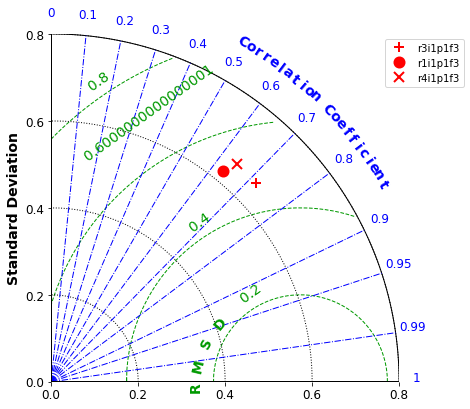

In [27]:
'''
How to create a simple Taylor diagram
A first example of how to create a simple Taylor diagram given one set of
reference observations and multiple model predictions for the quantity.
The Python code is kept to a minimum.
This example shows how to calculate the required statistics and produce
the Taylor diagram.
All functions in the Skill Metrics library are designed to only work with
one-dimensional arrays, e.g. time series of observations at a selected
location. The one-dimensional data are read in as dictionaries via a 
pickle file: ref['data'], pred1['data'], pred2['data'], 
and pred3['data']. The plot is written to a file in Portable Network 
Graphics (PNG) format.
The reference data used in this example are cell concentrations of a
phytoplankton collected from cruise surveys at selected locations and 
time. The model predictions are from three different simulations that
have been space-time interpolated to the location and time of the sample
collection. Details on the contents of the dictionary (once loaded) can 
be obtained by simply executing the following two statements
>> key_to_value_lengths = {k:len(v) for k, v in ref.items()}
>> print key_to_value_lengths
{'units': 6, 'longitude': 57, 'jday': 57, 'date': 57, 'depth': 57, 
'station': 57, 'time': 57, 'latitude': 57, 'data': 57}
Author: Peter A. Rochford
        Symplectic, LLC
        www.thesymplectic.com
Created on Dec 3, 2016
@author: prochford@thesymplectic.com
'''

if __name__ == '__main__':

    # Set the figure properties (optional)
    rcParams["figure.figsize"] = [8.0, 6.4]
    rcParams['lines.linewidth'] = 1 # line width for plots
    rcParams.update({'font.size': 12}) # font size of axes text
    
    # Close any previously open graphics windows
    # ToDo: fails to work within Eclipse
    plt.close('all')


    # Calculate statistics for Taylor diagram
    # The first array element (e.g. taylor_stats1[0]) corresponds to the 
    # reference series while the second and subsequent elements
    # (e.g. taylor_stats1[1:]) are those for the predicted series.
    
    
    # Store statistics in arrays
    sdev = np.array([taylor_stats_1['sdev'][0], taylor_stats_1['sdev'][1], 
                     taylor_stats_2['sdev'][1], taylor_stats_3['sdev'][1]])
    crmsd = np.array([taylor_stats_1['crmsd'][0], taylor_stats_1['crmsd'][1], 
                      taylor_stats_2['crmsd'][1], taylor_stats_3['crmsd'][1]])
    ccoef = np.array([taylor_stats_1['ccoef'][0], taylor_stats_1['ccoef'][1], 
                      taylor_stats_2['ccoef'][1], taylor_stats_3['ccoef'][1]])

    '''
    Produce the Taylor diagram
    Note that the first index corresponds to the reference series for 
    the diagram. For example sdev[0] is the standard deviation of the 
    reference series and sdev[1:4] are the standard deviations of the 
    other 3 series. The value of sdev[0] is used to define the origin 
    of the RMSD contours. The other values are used to plot the points 
    (total of 3) that appear in the diagram.
    For an exhaustive list of options to customize your diagram, 
    please call the function at a Python command line:
    >> taylor_diagram
    
    '''
    # Specify labels for points in a cell array (M1 for model prediction 1,
    # etc.). Note that a label needs to be specified for the reference even
    # though it is not used.
    #label = ['Non-Dimensional Observation', 'M1', 'M2', 'M3', 'M4', 'M5']
    
    
    label = ['Non-Dimensional Observation', str(subset_member_ids[1]), str(subset_member_ids[2]), str(subset_member_ids[3])]
    sm.taylor_diagram(sdev,crmsd,ccoef, markerlabel = label, markerLegend='on')

    # Write plot to file
    #plt.savefig('taylor1.png')

    # Show plot
    plt.show()